In [1]:
#%conda install bottleneck
#%conda install nc-time-axis

In [2]:
%conda install -c conda-forge xarray dask netCDF4 bottleneck xlrd


Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import bottleneck as bn
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from math import sqrt
import warnings
warnings.simplefilter('ignore')
import datetime
import xarray as xr

%matplotlib inline

In [4]:
fname = 'diversity-atualizado.xlsx'

In [5]:
df = pd.read_excel(fname, na_values=-99999)
df.head()

,chao,shannon,temp
0,194,3.466248,-1.56
1,194,3.466248,-1.56
2,194,3.466248,-1.56
3,194,3.466248,-1.56
4,140,3.261908,-1.54


In [6]:
chao = df['chao'] 
shannon = df['shannon']
temp = df['temp']

chaos = chao.rolling(window=3).mean()
shannons = shannon.rolling(window=3).mean()

temp = temp[~np.isnan(chaos)]
chaos = chaos[~np.isnan(chaos)]
shannons = shannons[~np.isnan(shannons)]

#print(shannons.head(10))

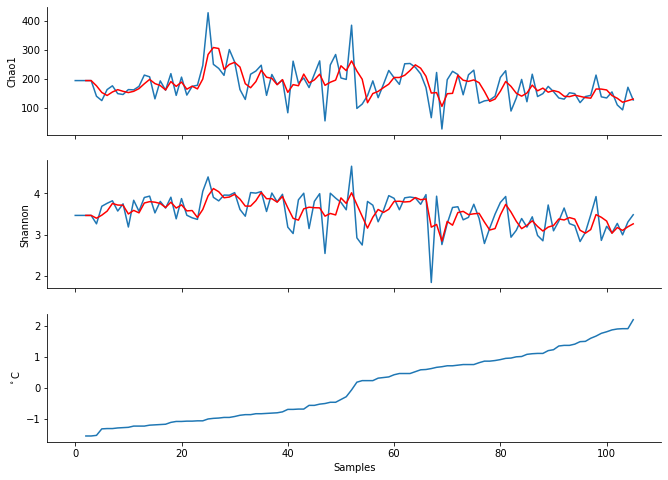

In [7]:
fig, (ax0, ax1,ax2) = plt.subplots(
    figsize=(11, 8),
    nrows=3,
    sharex=True,
)

chao.plot(ax=ax0); ax0.set_ylabel('Chao1')
chaos.plot(ax=ax0,color='red')

shannon.plot(ax=ax1); ax1.set_ylabel('Shannon')
shannons.plot(ax=ax1,color='red')

temp.plot(ax=ax2); ax2.set_ylabel('$^\circ$C'); ax2.set_xlabel('Samples')

ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(True)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(True)

ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(True)

In [8]:
Var_b = np.zeros((temp.shape[0],2))
Var_b[:,0] = temp
#print(Var_b)

X_train, X_validation, div_train, div_validation = train_test_split(Var_b, shannons, test_size=0.15)

In [9]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model

rf_random.fit(X_train, div_train)
print()

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   34.7s finished


In [10]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [rf_random.best_params_['bootstrap']],
    'max_depth': [rf_random.best_params_['max_depth']],
    'max_features': [rf_random.best_params_['max_features']],
    'min_samples_leaf': [rf_random.best_params_['min_samples_leaf']],
    'min_samples_split': [rf_random.best_params_['min_samples_split']],
    'n_estimators': [rf_random.best_params_['n_estimators']]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, div_train)
div_val = grid_search.predict(X_validation)

grid_search.best_estimator_.feature_importances_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished


array([1., 0.])

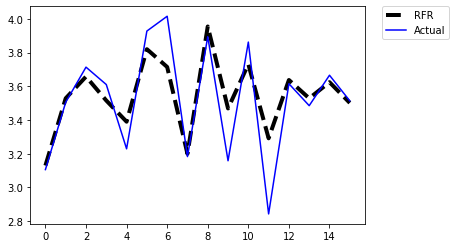

In [11]:
plt.plot(range(0,len(div_val)),div_val,'k--',linewidth=4,label="RFR")
plt.plot(range(0,len(div_validation)),div_validation,'b',label="Actual")  
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

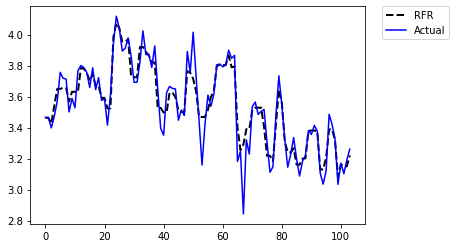

In [12]:
div_val = grid_search.predict(Var_b)

plt.plot(range(0,len(div_val)),div_val,'k--',linewidth=2,label="RFR")
plt.plot(range(0,len(shannons)),shannons,'b',label="Actual")  
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [13]:
sstSO126 = xr.open_dataarray('so_sst_126.nc')
sstSO126 = sstSO126.rolling(year=11, center=True).mean().dropna("year");
sstSO245 = xr.open_dataarray('so_sst_245.nc')
sstSO245 = sstSO245.rolling(year=3, center=True).mean().dropna("year");
sstSO370 = xr.open_dataarray('so_sst_370.nc')
sstSO370 = sstSO370.rolling(year=3, center=True).mean().dropna("year");
sstSO585 = xr.open_dataarray('so_sst_585.nc')
sstSO585 = sstSO585.rolling(year=3, center=True).mean().dropna("year");

In [14]:
VarSO126 = np.zeros((sstSO126.shape[0],2))
VarSO126[:,0] = sstSO126

VarSO245 = np.zeros((sstSO245.shape[0],2))
VarSO245[:,0] = sstSO245

VarSO370 = np.zeros((sstSO370.shape[0],2))
VarSO370[:,0] = sstSO370

VarSO585 = np.zeros((sstSO585.shape[0],2))
VarSO585[:,0] = sstSO585

Text(0.5, 0, 'Years')

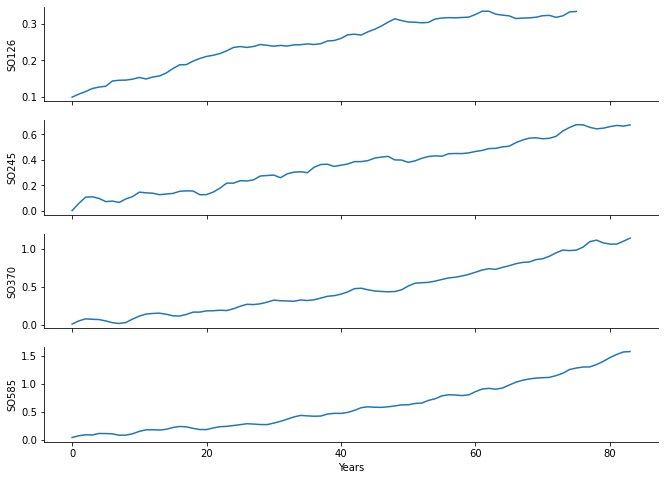

In [15]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(
    figsize=(11, 8),
    nrows=4,
    sharex=True,
)

ax0.plot(sstSO126); 
#ax0.plot(sstSO126.rolling(year=2, center=True).mean().dropna("year"));
ax1.plot(sstSO245); 

ax2.plot(sstSO370); 

ax3.plot(sstSO585); 

ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(True)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(True)
ax0.set_ylabel('SO126')

ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.set_ylabel('SO245')

ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(True)
ax2.set_ylabel('SO370')

ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(True)
ax3.set_ylabel('SO585')
ax3.set_xlabel('Years')

ds_surf = xr.combine_by_coords([sstSO126,sstSO245,sstSO370,sstSO585],compat='override')

Text(0.5, 0, 'Years')

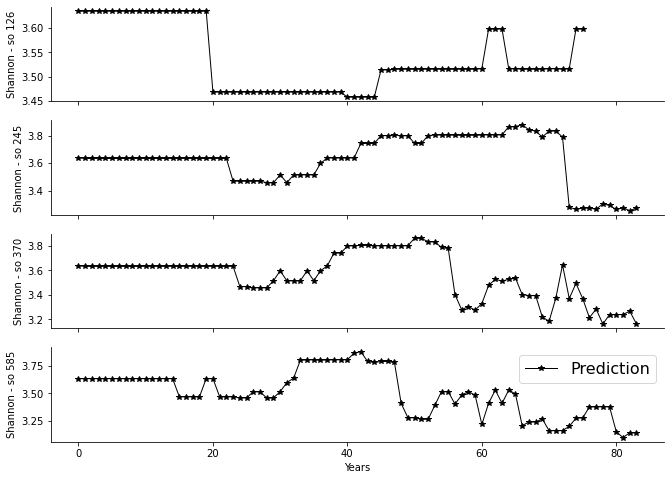

In [17]:
div_val = grid_search.predict(VarSO126)
div_val1 = grid_search.predict(VarSO245)
div_val2 = grid_search.predict(VarSO370)
div_val3 = grid_search.predict(VarSO585)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(
    figsize=(11, 8),
    nrows=4,
    sharex=True,
)

### removi o eixo de tempo para os teste pq o rolling do DataArray anula os primeiros valores
### para os teste não tem problema

ax0.plot(signal.medfilt(div_val,1),'k*-',linewidth=1,label="Prediction"); 

ax1.plot(signal.medfilt(div_val1,1),'k*-',linewidth=1,label="Prediction"); 

ax2.plot(signal.medfilt(div_val2,1),'k*-',linewidth=1,label="Prediction"); 

ax3.plot(signal.medfilt(div_val3,1),'k*-',linewidth=1,label="Prediction") 

#ax0.plot(ds_surf['year'],signal.medfilt(div_val,1),'k*-',linewidth=1,label="Prediction"); 
#ax1.plot(ds_surf['year'],signal.medfilt(div_val1,1),'k*-',linewidth=1,label="Prediction"); 
#ax2.plot(ds_surf['year'],signal.medfilt(div_val2,1),'k*-',linewidth=1,label="Prediction"); 
#ax3.plot(ds_surf['year'],signal.medfilt(div_val3,1),'k*-',linewidth=1,label="Prediction") 
plt.legend(loc='upper right',fontsize=16); 

ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(True)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(True)
ax0.set_ylabel('Shannon - so 126')

ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.set_ylabel('Shannon - so 245')

ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(True)
ax2.set_ylabel('Shannon - so 370')

ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(True)
ax3.set_ylabel('Shannon - so 585')
ax3.set_xlabel('Years')

In [19]:
sstWED126 = xr.open_dataarray('wed_sst_126.nc')
sstWED126 =sstWED126.rolling(year=2, center=True).mean().dropna("year");
sstWED245 = xr.open_dataarray('wed_sst_245.nc')
sstWED245 =sstWED245.rolling(year=2, center=True).mean().dropna("year");
sstWED370 = xr.open_dataarray('wed_sst_370.nc')
sstWED370 = sstWED370.rolling(year=2, center=True).mean().dropna("year");
sstWED585 = xr.open_dataarray('wed_sst_585.nc')
sstWED585 = sstWED585.rolling(year=2, center=True).mean().dropna("year");

In [20]:
VarWED126 = np.zeros((sstWED126.shape[0],2))
VarWED126[:,0] = sstWED126
VarWED245 = np.zeros((sstWED245.shape[0],2))
VarWED245[:,0] = sstWED245
VarWED370 = np.zeros((sstWED370.shape[0],2))
VarWED370[:,0] = sstWED370
VarWED585 = np.zeros((sstWED585.shape[0],2))
VarWED585[:,0] = sstWED585

Text(0.5, 0, 'Years')

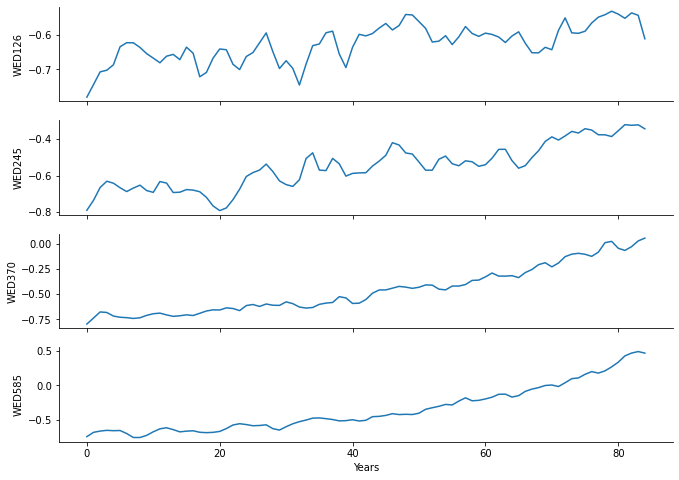

In [21]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(
    figsize=(11, 8),
    nrows=4,
    sharex=True,
)

ax0.plot(sstWED126);

ax1.plot(sstWED245); 

ax2.plot(sstWED370); 

ax3.plot(sstWED585); 

ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(True)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(True)
ax0.set_ylabel('WED126')

ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.set_ylabel('WED245')

ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(True)
ax2.set_ylabel('WED370')

ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(True)
ax3.set_ylabel('WED585')
ax3.set_xlabel('Years')

ds_surf1 = xr.combine_by_coords([sstWED126,sstWED245,sstWED370,sstWED585],compat='override')

Text(0.5, 0, 'Years')

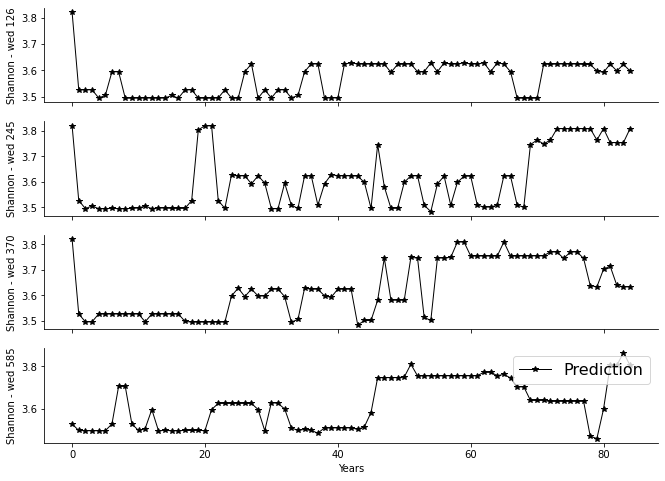

In [22]:
div_val4 = grid_search.predict(VarWED126)
div_val5 = grid_search.predict(VarWED245)
div_val6 = grid_search.predict(VarWED370)
div_val7 = grid_search.predict(VarWED585)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(
    figsize=(11, 8),
    nrows=4,
    sharex=True,
)

### removi o eixo de tempo para os teste pq o rolling do DataArray anula os primeiros valores
### para os teste não tem problema

ax0.plot(signal.medfilt(div_val4,1),'k*-',linewidth=1,label="Prediction"); 

ax1.plot(signal.medfilt(div_val5,1),'k*-',linewidth=1,label="Prediction"); 

ax2.plot(signal.medfilt(div_val6,1),'k*-',linewidth=1,label="Prediction"); 

ax3.plot(signal.medfilt(div_val7,1),'k*-',linewidth=1,label="Prediction") 

#ax0.plot(ds_surf['year'],signal.medfilt(div_val4,1),'k*-',linewidth=1,label="Prediction"); 
#ax1.plot(ds_surf['year'],signal.medfilt(div_val5,1),'k*-',linewidth=1,label="Prediction"); 
#ax2.plot(ds_surf['year'],signal.medfilt(div_val6,1),'k*-',linewidth=1,label="Prediction"); 
#ax3.plot(ds_surf['year'],signal.medfilt(div_val7,1),'k*-',linewidth=1,label="Prediction") 
plt.legend(loc='upper right',fontsize=16); 

ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(True)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(True)
ax0.set_ylabel('Shannon - wed 126')

ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.set_ylabel('Shannon - wed 245')

ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(True)
ax2.set_ylabel('Shannon - wed 370')

ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(True)
ax3.set_ylabel('Shannon - wed 585')
ax3.set_xlabel('Years')

In [23]:
sstBELL126 = xr.open_dataarray('bell_sst_126.nc')
sstBELL126 = sstBELL126.rolling(year=5, center=True).mean().dropna("year");
sstBELL245 = xr.open_dataarray('bell_sst_245.nc')
sstBELL245 = sstBELL245.rolling(year=5, center=True).mean().dropna("year");
sstBELL370 = xr.open_dataarray('bell_sst_370.nc')
sstBELL370 = sstBELL370.rolling(year=5, center=True).mean().dropna("year");
sstBELL585 = xr.open_dataarray('bell_sst_585.nc')
sstBELL585 = sstBELL585.rolling(year=5, center=True).mean().dropna("year");
#print(sstBELL126)

In [24]:
VarBELL126 = np.zeros((sstBELL126.shape[0],2))
VarBELL126[:,0] = sstBELL126
VarBELL245 = np.zeros((sstBELL245.shape[0],2))
VarBELL245[:,0] = sstBELL245
VarBELL370 = np.zeros((sstBELL370.shape[0],2))
VarBELL370[:,0] = sstBELL370
VarBELL585 = np.zeros((sstBELL585.shape[0],2))
VarBELL585[:,0] = sstBELL585

Text(0.5, 0, 'Years')

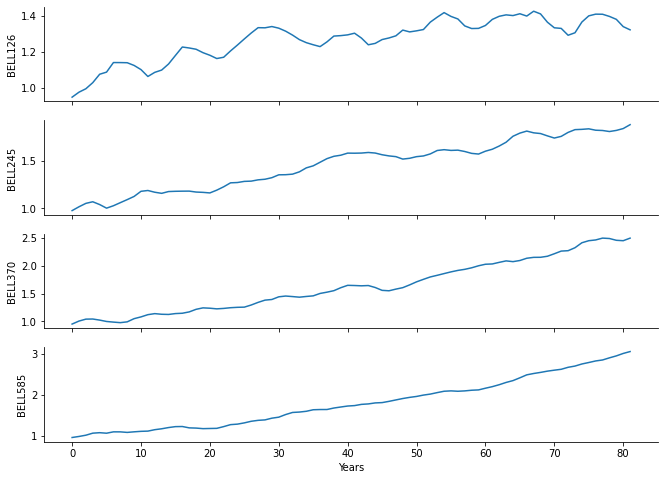

In [25]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(
    figsize=(11, 8),
    nrows=4,
    sharex=True,
)

ax0.plot(sstBELL126);
#ax0.plot(sstWED126.rolling(year=2, center=True).mean().dropna("year"))

ax1.plot(sstBELL245); 

ax2.plot(sstBELL370); 

ax3.plot(sstBELL585); 

ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(True)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(True)
ax0.set_ylabel('BELL126')

ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.set_ylabel('BELL245')

ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(True)
ax2.set_ylabel('BELL370')

ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(True)
ax3.set_ylabel('BELL585')
ax3.set_xlabel('Years')

ds_surf1 = xr.combine_by_coords([sstBELL126.to_dataset(name='a'),
                                 sstBELL245.to_dataset(name='b'),
                                 sstBELL370.to_dataset(name='c'),
                                 sstBELL585.to_dataset(name='d')],compat='override')
print(ds_surf1)

Text(0.5, 0, 'Years')

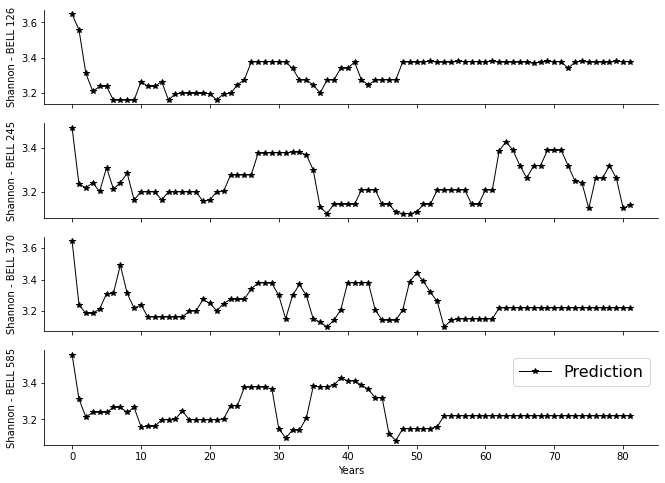

In [26]:
div_val4 = grid_search.predict(VarBELL126)
div_val5 = grid_search.predict(VarBELL245)
div_val6 = grid_search.predict(VarBELL370)
div_val7 = grid_search.predict(VarBELL585)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(
    figsize=(11, 8),
    nrows=4,
    sharex=True,
)

ax0.plot(signal.medfilt(div_val4,1),'k*-',linewidth=1,label="Prediction"); 

ax1.plot(signal.medfilt(div_val5,1),'k*-',linewidth=1,label="Prediction"); 

ax2.plot(signal.medfilt(div_val6,1),'k*-',linewidth=1,label="Prediction"); 

ax3.plot(signal.medfilt(div_val7,1),'k*-',linewidth=1,label="Prediction") 
plt.legend(loc='upper right',fontsize=16); 

ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(True)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(True)
ax0.set_ylabel('Shannon - BELL 126')

ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.set_ylabel('Shannon - BELL 245')

ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(True)
ax2.set_ylabel('Shannon - BELL 370')

ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(True)
ax3.set_ylabel('Shannon - BELL 585')
ax3.set_xlabel('Years')